In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv
load_dotenv()

engine = sa.create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
    .format(host=os.getenv('host'), db=os.getenv('db'), user=os.getenv('uname'), pw=os.getenv('password')))

## Make Prime table in DB

In [2]:
df = pd.read_csv("prime.csv")
df['DATE'] = pd.to_datetime(df['DATE'])

df.to_sql(name="prime_rates", con= engine, if_exists='replace', index=False)

query_mod_date_col = """ALTER TABLE `sba`.`prime_rates` 
CHANGE COLUMN `DATE` `DATE` DATE NOT NULL ,
ADD UNIQUE INDEX `DATE_UNIQUE` (`DATE` ASC);
;"""

engine.execute(query_mod_date_col)

# query to add date and year columns for easier joins
add_mth_year_queries = []
add_mth_year_queries.append(sa.text("ALTER TABLE prime_rates ADD COLUMN p_MONTH int NULL AFTER date ;"))
add_mth_year_queries.append(sa.text("ALTER TABLE prime_rates ADD COLUMN p_YEAR int NULL AFTER date ;"))
add_mth_year_queries.append(sa.text("UPDATE prime_rates SET prime_rates.p_MONTH = MONTH(prime_rates.`DATE`);"))
add_mth_year_queries.append(sa.text("UPDATE prime_rates SET prime_rates.p_YEAR = YEAR(prime_rates.`DATE`);"))

                # INSERT INTO prime_rates(month) FROM prime_rates;
for q in add_mth_year_queries:
    engine.execute(q)

prime_df = pd.read_sql("SELECT * FROM sba.prime_rates",engine)

In [3]:
prime_annual = prime_df[prime_df.columns[1:]].groupby('p_YEAR').mean()[['PRIME']].reset_index()
prime_annual = prime_annual[prime_annual['p_YEAR']>=2000]
prime_df = prime_df[prime_df['p_YEAR']>=2000]

## Read in loan data, format dates

In [4]:
loan_df = pd.read_sql('SELECT * FROM clean_version', con=engine)
date_cols = [c for c in loan_df.columns if 'Dt' in c]
for c in date_cols:
    loan_df[c] = pd.to_datetime(loan_df[c])
loan_df['Note_Yr'] = loan_df['NoteDt'].dt.year
loan_df['Note_Mth'] = loan_df['NoteDt'].dt.month
first_cols = ['GP','Note_Yr','Note_Mth'] 
formatted_order = first_cols + [c for c in loan_df.columns if c not in first_cols]
loan_df = loan_df[formatted_order] 
loan_df.head()
test_df = loan_df[loan_df['MatBucket']=='21+']
gp_checks = loan_df[loan_df['PrepayMthsQty']==0]['GP'].to_list()

for gp in gp_checks: 
    failed_gps = []
    gp_query = f"SELECT EffectiveDt, TransactionBalanceAmt from FIN_FINAL where ObservationNmb = {gp} AND GeneralLedgerCd in (6031,1510) ORDER BY EffectiveDt;"
    test_gp = pd.read_sql(gp_query, engine)
    # case_1 --> where there are two instances of the balance being zero:
    zero_counts= test_gp[test_gp['TransactionBalanceAmt']==0].shape[0]
    if zero_counts > 1:
        failed_gps.append(gp)
    else:
    # case_2 --> where there is one zero but the loan is still outstanding
        if test_gp.tail(1)['TransactionBalanceAmt'].values[-1]>0:
        # action for case_2 --> go to table and change the PrepayDt column and PrepayMthsQty Column to Null
            loan_df.loc[loan_df['GP']==gp,'PrepayMthsQty'] = np.nan
            loan_df.loc[loan_df['GP']==gp,'PrepayDt'] = pd.NaT


In [5]:
loan_df.to_sql("clean_version_2", engine, if_exists="replace")

820500

In [6]:
loan_df = pd.read_csv('clean_loans.csv')
loan_df = loan_df[[c for c in loan_df.columns if 'unnamed' not in c.lower()] ]

In [7]:
def coalesce_least(row):
    a = row['PrepayMthsQty']
    b = row['DefaultMthsQty']
    if pd.isnull(a):
        return b
    elif pd.isnull(b):
        return a
    else:
        return min(a, b)
    
loan_df['PP_Qty'] = loan_df[['PrepayMthsQty','DefaultMthsQty']].apply(coalesce_least, axis=1)



In [8]:
test_df = loan_df[loan_df['MatBucket']=='8-11']

test_df['Distance_to_Maturity'] = test_df['MaturityMthsQty'] - test_df['PP_Qty']

test_df = test_df[test_df['Distance_to_Maturity'].notna()]

bins = [0,12,24,48,60,72,np.inf]
test_df['mths_remaining_bucket'] = pd.cut(test_df['Distance_to_Maturity'], bins=bins)


mths_remaining = test_df[test_df['PP_Qty']>=60].groupby('mths_remaining_bucket').count()[['GP']].reset_index()


mths_remaining['mths_remaining_bucket'] = mths_remaining['mths_remaining_bucket'].astype(str)
mths_remaining['mths_remaining_bucket'] = mths_remaining['mths_remaining_bucket'].str.replace('\(','')
mths_remaining['mths_remaining_bucket'] = mths_remaining['mths_remaining_bucket'].str.replace(',',' -')
mths_remaining['mths_remaining_bucket'] = mths_remaining['mths_remaining_bucket'].str.replace(']','')
mths_remaining['mths_remaining_bucket'] = mths_remaining['mths_remaining_bucket'].str.replace('- inf','+')




In [9]:

# bins = [0,12,24,48,60,72,np.inf]
# test_df['MoB_bucket'] = pd.cut(test_df['PP_Qty'], bins=bins)

# mob = test_df.groupby('MoB_bucket').count()[['GP']].reset_index()

# mob['MoB_bucket'] = mob['MoB_bucket'].astype(str)
# mob['MoB_bucket'] = mob['MoB_bucket'].str.replace('\(','')
# mob['MoB_bucket'] = mob['MoB_bucket'].str.replace(',',' -')
# mob['MoB_bucket'] = mob['MoB_bucket'].str.replace(']','')
# mob['MoB_bucket'] = mob['MoB_bucket'].str.replace('- inf','+')
# mob.to_csv('mob_8-11.csv')

## Do Year cut-off on WAL

<AxesSubplot: xlabel='Note_Yr,Note_Mth'>

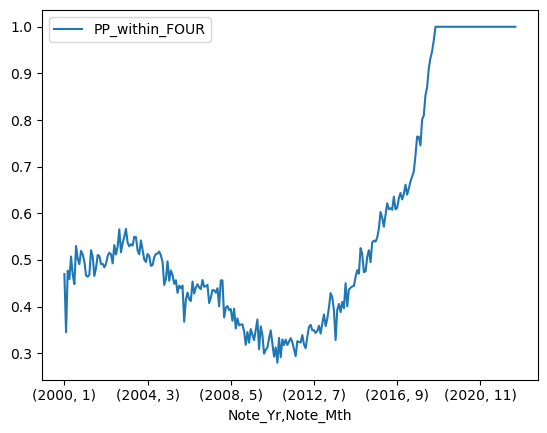

In [10]:
group_df = test_df[['Note_Yr','Note_Mth','PP_Qty']].groupby(['Note_Yr','Note_Mth'])['PP_Qty'].agg(total_count= 'count', PP_within_FOUR= lambda x: x[x<=48].count()/len(x), \
                                                    PP_within_SEVEN= lambda x: x[x<=86].count()/len(x) )

group_df[['PP_within_FOUR']].plot()

## WAL Charts and grouping

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def wal(grp):
    return ( round((grp['LoanAmt'] * grp['PP_Qty']).sum() / grp['LoanAmt'].sum() /12, 2) )  



def get_prime_rate(grp, p_df:pd.DataFrame)-> float:
    temp_df = p_df[p_df['yr']==grp['yr']]
    values = temp_df[temp_df['mth']==grp['mth']]['PRIME'].values
    if len(values)>0:
        if values[-1] > 10:
            display(temp_df[temp_df['mth']==grp['mth']])
        return values[-1]
    else:
        mth_to_find = grp['mth']
        for idx, temp_row in temp_df.iterrows():
            if temp_row['mth'] > mth_to_find and idx > 0:
                if temp_df.at[idx,'PRIME'] > 10: 
                    display(temp_df.iloc[idx, 'PRIME'])
                return temp_df.at[idx,'PRIME']                

        

if 'Note_Yr' in test_df.columns:
    test_df = test_df.rename(columns={'Note_Yr':'yr','Note_Mth':'mth'})
    
wal_groups = test_df[['GP','yr','mth','LoanAmt','PP_Qty']].groupby(['yr','mth'])[['LoanAmt','PP_Qty']].apply(wal)
wal_groups = pd.DataFrame(wal_groups)

wal_groups = wal_groups.rename(columns={0: 'wal'}).reset_index()
# create a grouped prime df (indexed on year and month)
prime_df = prime_df.rename(columns={'p_YEAR':'yr', 'p_MONTH':'mth'})
prime = prime_df.groupby(['yr','mth']).last()[['PRIME']].reset_index()

new_col = []
for _, row in wal_groups[['yr','mth']].iterrows():
    new_col.append(  get_prime_rate(row, prime))

wal_groups['PRIME'] = pd.Series(new_col)
# # create a multiindex with all possible yr mth combos
# full_index = pd.MultiIndex.from_product([list(range(wal_groups['yr'].min(),wal_groups['yr'].max()+1)), list(range(1,13)) ]  ) 
# wal_groups = wal_groups.set_index(['yr','mth'])
# # ffill the prime df with new index
# prime = prime.set_index(['yr','mth']).reindex(full_index).ffill().reset_index().rename(columns={'level_0':'yr'	,'level_1':'mth'}).set_index(['yr','mth']).fillna(method='bfill')
# # join prime rate data on weighted average life data
# wal_groups = wal_groups.merge(prime,left_index=True, right_index=True)
# wal_groups = wal_groups.reset_index()

In [12]:
wal_groups

,yr,mth,wal,PRIME
0,2000,1,4.92,9.00
1,2000,2,5.35,8.75
2,2000,3,4.66,9.00
3,2000,4,4.77,9.50
4,2000,5,4.49,9.50
...,...,...,...,...
267,2022,4,0.41,4.00
268,2022,5,0.18,4.00
269,2022,6,0.16,4.75
270,2022,7,0.08,5.50


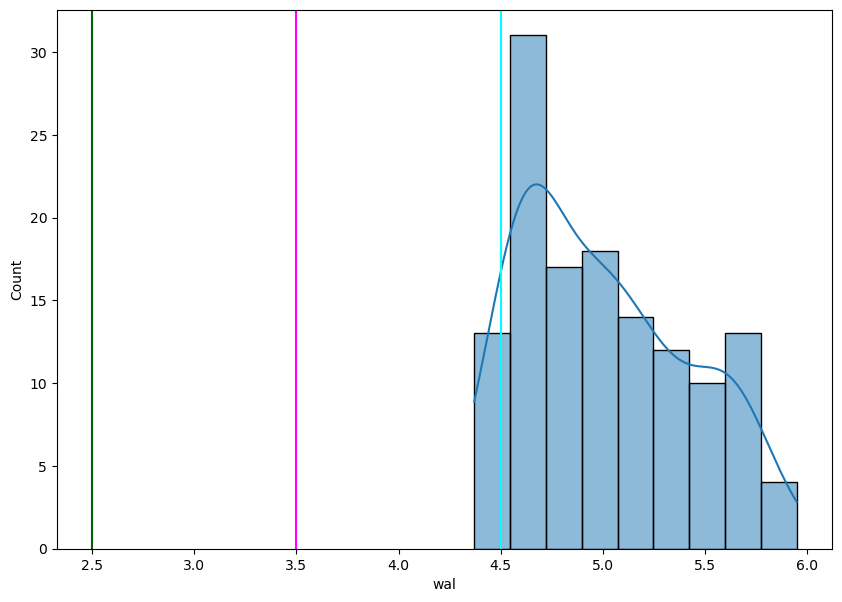

In [14]:
fig, ax = plt.subplots(figsize=(10,7))

g = sns.histplot(data=wal_groups[wal_groups['yr']<=2010], x='wal', ax=ax, kde=True)
g.axvline(x=2.5, color='darkgreen')
g.axvline(x=3.5, color='magenta')
g.axvline(x=4.5, color='cyan')


In [17]:
wal_groups[wal_groups['yr']<=2010].to_csv('for_mir.csv')

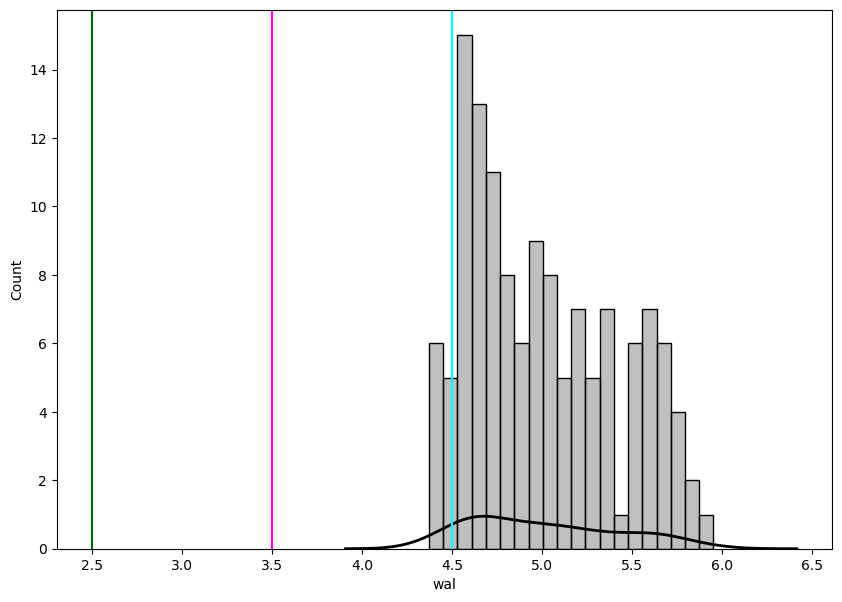

In [15]:
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(data=wal_groups[wal_groups['yr']<=2010], x='wal', ax=ax, kde=False, color='gray', bins=20, alpha=0.5)
sns.kdeplot(data=wal_groups[wal_groups['yr']<=2010], x='wal', ax=ax, color='black', linewidth=2)

ax.axvline(x=2.5, color='darkgreen')
ax.axvline(x=3.5, color='magenta')
ax.axvline(x=4.5, color='cyan')

plt.show()

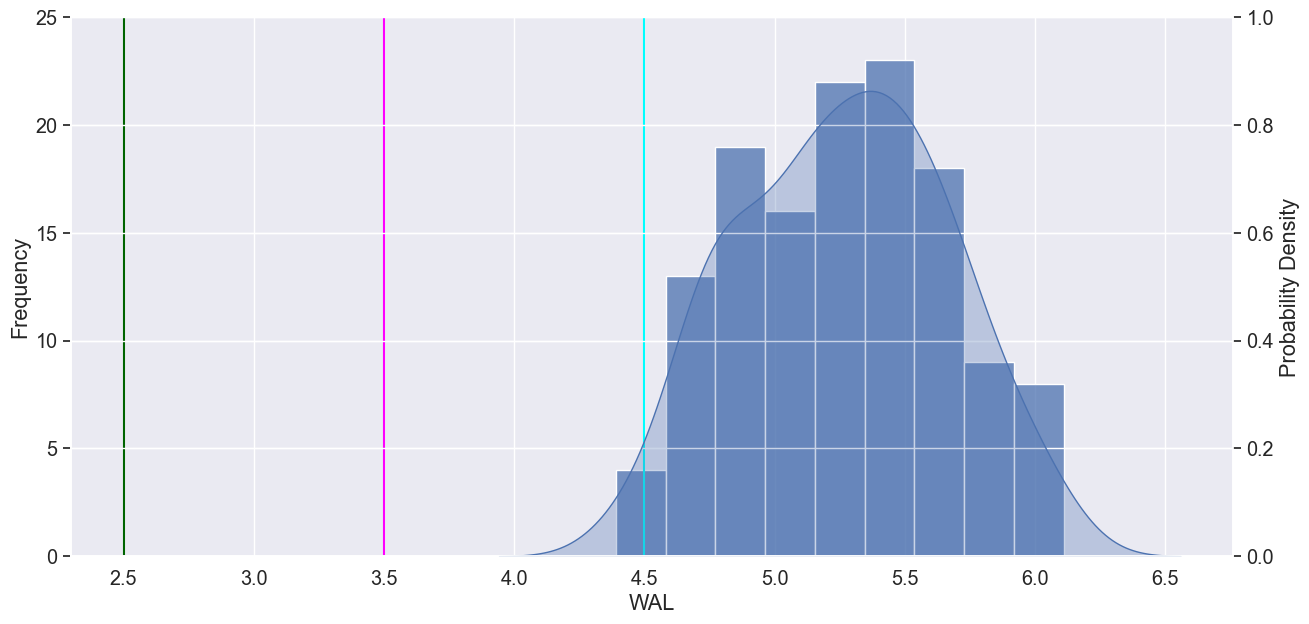

In [185]:
fig, ax = plt.subplots(figsize=(15,7))

# Plot histogram
sns.histplot(data=wal_groups[wal_groups['yr']<=2010], x='wal', ax=ax, kde=False)
ax.set_xlabel('WAL')
ax.set_ylabel('Frequency')
ax.set_ylim(0,25)
ax.axvline(x=2.5, color='darkgreen')
ax.axvline(x=3.5, color='magenta')
ax.axvline(x=4.5, color='cyan')
# Create secondary y-axis
sec_ax = ax.twinx()

# Plot KDE on secondary y-axis
sns.kdeplot(data=wal_groups[wal_groups['yr']<=2010], x='wal', ax=sec_ax, palette='Blues', fill=True, alpha=.3)
sec_ax.set_ylabel('Probability Density')

# Set y-limits for secondary y-axis
sec_ax.set_ylim(0, 1)

# # Add legend
# ax.legend(['Histogram'])
# sec_ax.legend(['KDE'], loc='upper right')

plt.show()

## WAL - Prime Rate Distribution with Break-Even REFLINE

[Text(0, 0.0, '0.00%'),
 Text(0, 2.0, '2.00%'),
 Text(0, 4.0, '4.00%'),
 Text(0, 6.0, '6.00%'),
 Text(0, 8.0, '8.00%'),
 Text(0, 10.0, '10.00%'),
 Text(0, 12.0, '12.00%')]

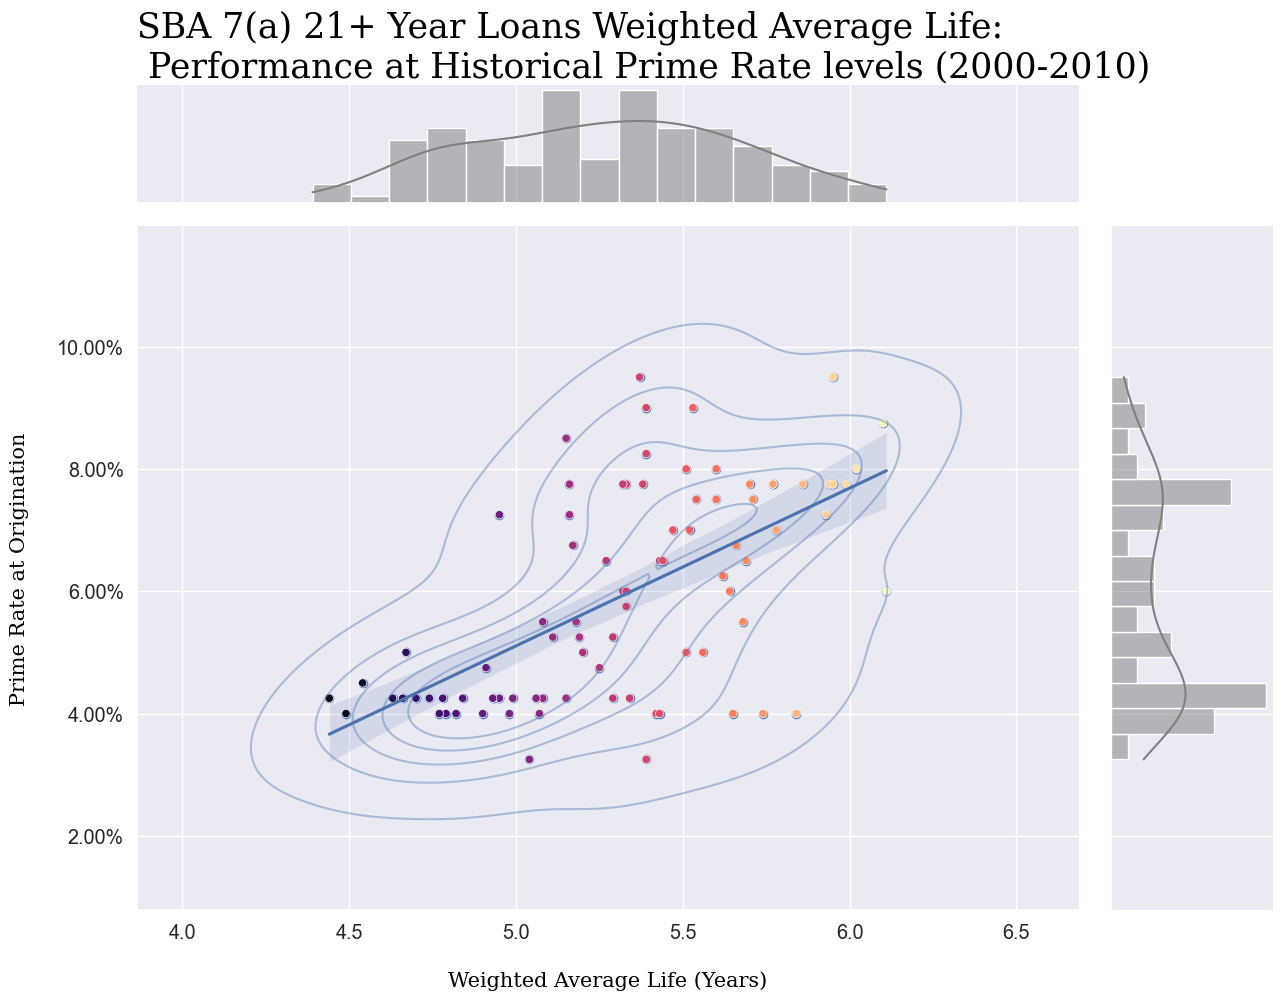

In [158]:
# Create a single plot
import matplotlib.pyplot as plt
font1 = {'family':'serif','color':'black','size':15}


font2 = {'family':'serif','color':'black','size':25}

sns.set_style("darkgrid")
sns.set_context("poster")
sns.set(font_scale=1.3)

g = sns.jointplot(data=wal_groups[wal_groups['yr']<=2010], x='wal', y='PRIME', kind='reg', palette='viridis', marginal_kws=dict(bins=15,fill=True, color='gray'))
g = g.plot_joint(sns.kdeplot, levels=6, alpha=0.4, style='-')
g = g.plot_joint(sns.scatterplot, hue=wal_groups[wal_groups['yr']<=2010]['wal'], palette='magma', legend=False)
g.fig.set_size_inches(14,10)
g.set_axis_labels(xlabel='Weighted Average Life (Years)', ylabel='Prime Rate at Origination', fontdict=font1, labelpad = 20)
g.figure.axes[1].set_title('SBA 7(a) 21+ Year Loans Weighted Average Life:\n Performance at Historical Prime Rate levels (2000-2010)',loc='left', fontdict=font2)
# g.refline(x=2.5, color='darkgreen')
# g.refline(x=3.5, color='magenta')
# g.refline(x=4.5, color='cyan')
all_axes = [ax for ax in g.figure.axes]
vals = all_axes[0].get_yticks()
vals = [(v/100) for v in vals]
all_axes[0].set_yticklabels(['{:,.2%}'.format(x) for x in vals])

# ax.set_yticklabels(['{:,2%}'.format(x) for x in vals])


In [29]:
wal_groups

,yr,mth,wal,PRIME
0,2000,1,5.39,9.00
1,2000,2,6.10,8.75
2,2000,3,5.39,9.00
3,2000,4,5.37,9.50
4,2000,5,5.95,9.50
...,...,...,...,...
270,2022,7,0.00,5.50
271,2022,8,0.00,6.25
272,2022,9,0.00,6.25
273,2022,10,NaN,7.00


Text(0.5, 1.0, '21+ Year Maturity SBA 7(a)\n Weighted Average Life: 2000-2010')

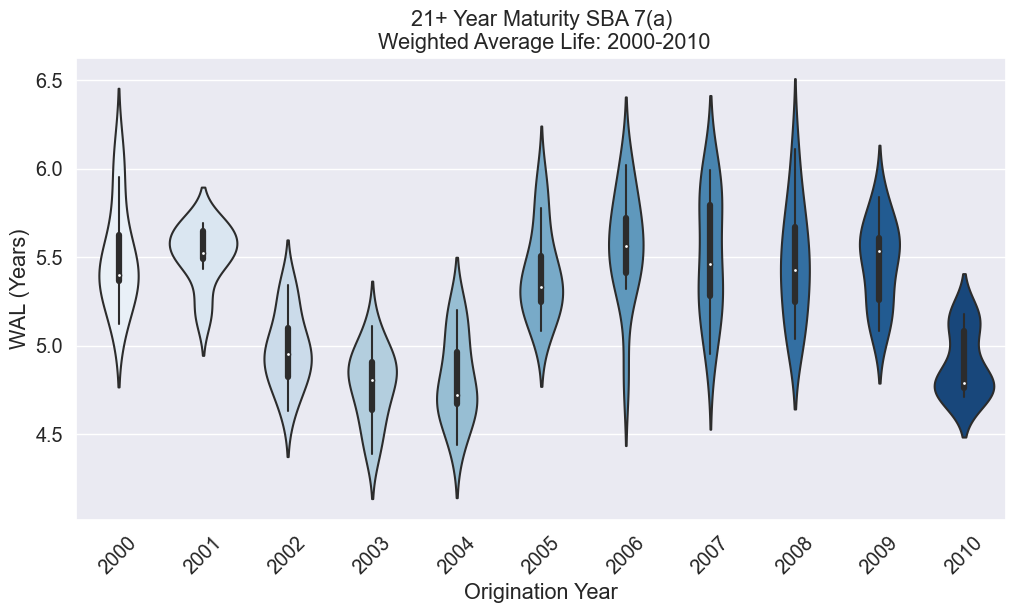

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,6))

g = sns.violinplot(x='yr', y='wal', data=wal_groups[wal_groups['yr']<=2010], palette='Blues')

# sns.lineplot(x='yr', y='PRIME',data=wal_groups[wal_groups['yr']<=2010], ax = ax2, legend=False)

plt.xticks(rotation=45)
plt.xlabel(xlabel='Origination Year')
plt.ylabel(ylabel="WAL (Years)")
plt.title(label="21+ Year Maturity SBA 7(a)\n Weighted Average Life: 2000-2010")



<AxesSubplot: ylabel='PRIME'>

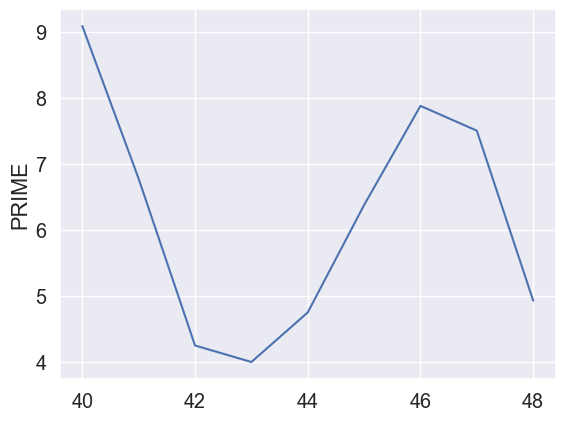

In [31]:
sns.lineplot(data=prime_annual[prime_annual['p_YEAR']<=2010]['PRIME'])

## Survivorship

In [33]:
test_df

,GP,yr,mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,DefaultMthsQty,MatBucket,PP_Qty
201,4435462,2008,4,2008-04-30,378000.00,2031-03-30,275,2019-12-11,139.0,2019-08-23,135.0,21+,135.0
240,1483193,2000,2,2000-02-29,1000000.00,2025-01-27,298,2002-10-22,31.0,2000-12-20,9.0,21+,9.0
246,887167,2000,8,2000-08-30,1108000.00,2024-11-30,291,2002-07-28,22.0,NaN,NaN,21+,22.0
250,1477340,2000,1,2000-01-31,1500000.00,2022-01-31,264,2009-05-27,111.0,2000-09-22,7.0,21+,7.0
260,1478838,2000,3,2000-03-31,1000000.00,2025-03-31,300,2007-07-16,87.0,2001-01-18,9.0,21+,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
820481,18024283,2022,8,2022-08-25,1550000.00,2047-08-25,300,NaN,NaN,NaN,NaN,21+,NaN
820485,18025249,2022,8,2022-08-19,1717000.00,2047-08-09,299,NaN,NaN,NaN,NaN,21+,NaN
820486,18025684,2022,8,2022-08-19,229838.94,2047-08-11,299,NaN,NaN,NaN,NaN,21+,NaN
820491,18026016,2022,9,2022-09-01,1275000.00,2047-08-03,299,NaN,NaN,NaN,NaN,21+,NaN


In [34]:
# Group by year and month of origination
df_grouped = test_df.groupby(['yr', 'mth'])


def balance_rundown(grp):
    balance_dict = {}
    start_balance = grp['LoanAmt'].sum()
    balance_dict[0] = start_balance
    months_to_track = list(range(0, 121, 6))
    # Loop through each month and calculate balance rundown
    for month in months_to_track[1:]:
        # Remove loans with PP_Qty less than or equal to x months
        balance =round(grp.loc[(grp['PP_Qty'] > month) | (grp['PP_Qty'].isna()), 'LoanAmt'].sum(),2)
        # Add remaining balance to dictionary
        balance_dict[month] = balance
    
    return balance_dict


def loan_count(grp, date_str):
    loan_count_dict = {}
    n_loans = grp['GP'].count()
    loan_count_dict[0] = n_loans
    months_to_track = list(range(0, 252, 1))
    curr_time = dt.datetime.now()
    for month in months_to_track[1:]:
        test_date = pd.to_datetime(date_str) + np.timedelta64(month,'M')
        # conidition == FALSE if the test_date is LESS than the curr_date
        condition = test_date > curr_time
        if not condition:
        # Filter loans with PP_Qty greater than month or missing values
            outstanding_loans = grp.loc[(grp['PP_Qty'] > month) | (grp['PP_Qty'].isna())]
            # Count the number of outstanding loans
            n_outstanding_loans = outstanding_loans['GP'].count()
            # Add the number of outstanding loans to the dictionary
            loan_count_dict[month] = n_outstanding_loans
    return loan_count_dict

master_dict = {}
for name, grp in df_grouped:
    x = name
    yr = [y for y in x][0]
    mth = [y for y in x][1]

    date_str = f"{yr}-{mth}"
    master_dict[name] = loan_count(grp, date_str)
    

In [35]:
df_sample = pd.DataFrame(master_dict)
my_range = list(range(0,252,1))

# long way -- probs a way to vectorize this

data = {}
for idx, row in df_sample.transpose().iterrows():
    cohort_name = f"{idx[0]}-{idx[1]}"
    data_row = (row.to_list())
    survivorship = [round(100*(1-(data_row[0]-d)/data_row[0]), 3) for d in data_row]
    data[cohort_name] = survivorship
    


In [36]:
# pd.DataFrame(data).plot(figsize=(12,10), grid=True)
import plotly.express as px
surv = pd.DataFrame(data)

# fig = px.line(data_frame=surv, line_shape='linear')
# fig.show()
# surv.plot(figsize=(15,10), grid=True)

In [37]:
surv['mean'] = surv.mean(axis=1)
surv['stdev'] = surv.std(axis=1)
surv['+3sig']= surv['mean']+3*surv['stdev']
surv.loc[surv['+3sig']>100,'+3sig'] = 100
surv['-3sig']= surv['mean']-3*surv['stdev']
surv.loc[surv['-3sig']<0,'-3sig'] = 0

In [38]:
surv = surv.drop(columns='stdev')

In [39]:
surv[surv.columns[-3:]]

,mean,+3sig,-3sig
0,100.000000,100.000000,100.000000
1,99.957869,100.000000,99.517911
2,99.906196,100.000000,99.288724
3,99.825880,100.000000,98.989547
4,99.752259,100.000000,98.804687
...,...,...,...
247,4.967156,8.839373,1.094939
248,4.923774,8.883248,0.964301
249,4.824200,8.469687,1.178713
250,4.835586,8.186355,1.484817


In [41]:
# sns.relplot(data=surv[surv.columns[-3:]], kind='line', height=8.27, aspect=11.7/8.27)

In [157]:
surv.iloc[1:85][surv.columns[0:-3]].to_csv('surv_rates_sevenyr.csv')

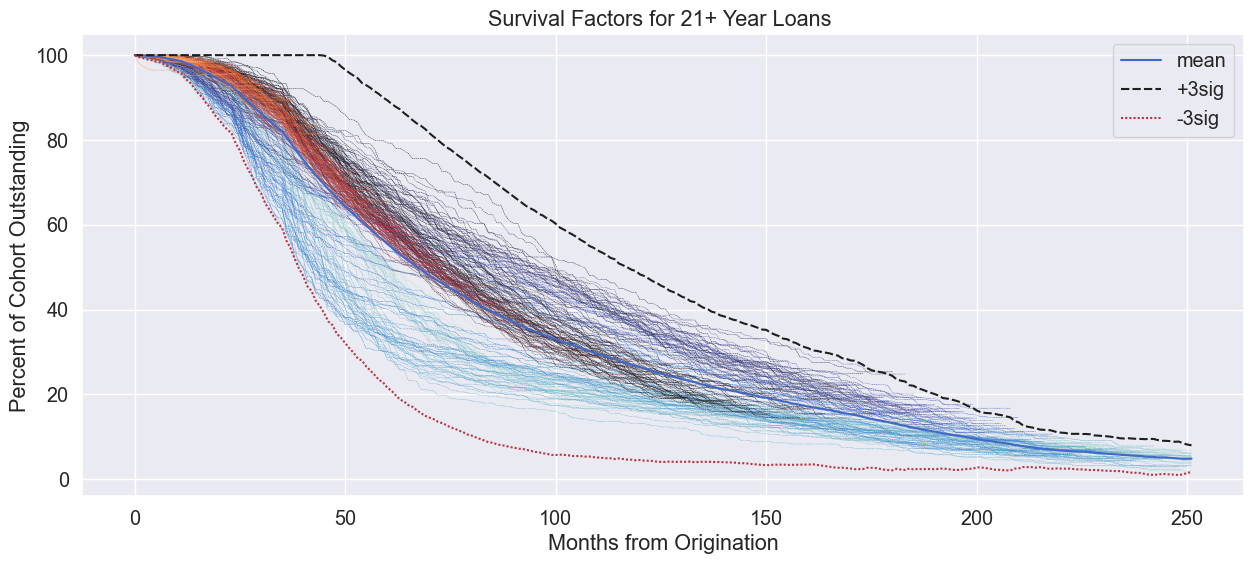

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a single plot
fig, ax = plt.subplots(figsize=(15, 6))

sns.set_style("darkgrid")

# all cohort survivorship
fig_1 =sns.lineplot(data=surv[surv.columns[:-4]], alpha=1, ax=ax, legend=False, palette="icefire", linewidth=.35)

# Plot the line chart on the same axis
sns.lineplot(data=surv[surv.columns[-3:]], palette='icefire')

# sns.color_palette("Paired")
# Add titles and labels to the plot
ax.set_title("Survival Factors for 21+ Year Loans ")
ax.set_xlabel("Months from Origination")
ax.set_ylabel("Percent of Cohort Outstanding")

# Show the plot
plt.show()

In [ ]:
# import seaborn as sns

# fig_1 = sns.relplot(data=surv[surv.columns[:-4]], kind="scatter", alpha=.5, height=8.27, aspect=11.7/8.27)

# fig_1._legend.remove()


In [ ]:
pd.DataFrame(master_dict)

In [ ]:
prime_df.head()

,DATE,p_YEAR,p_MONTH,PRIME
0,1955-08-04,1955,8,3.25
1,1955-10-14,1955,10,3.50
2,1956-04-13,1956,4,3.75
3,1956-08-21,1956,8,4.00
4,1957-08-06,1957,8,4.50
